# Imports

In [130]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
%autoreload 2
from src import *
import numpy as np
import matplotlib.pyplot as plt

In [132]:
seed=42

In [133]:
N = 128
L = Laplacian((N,N), mode="wrap")
L2 = L.gram()

In [134]:
# plt.subplot(121)
# plt.title("L pyxu operator")
# plt.imshow(L.asarray())
# plt.subplot(122)
# plt.title(r"$L^\top L$ pyxu operator")
# plt.imshow(L2.asarray(), cmap="tab20c")
# plt.colorbar();

(-0.5, 127.5, 127.5, -0.5)

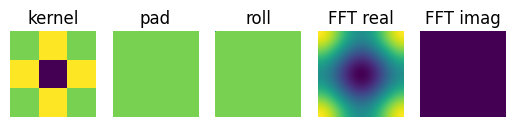

In [135]:
plt.subplot(151)
plt.title("kernel")
Lconv = np.array([[0,1,0],[1,-4,1], [0,1,0]])
plt.imshow(Lconv)
plt.axis("off")

plt.subplot(152)
plt.title("pad")
Lpad = np.pad(Lconv,((0,N-3),(0,N-3)))
plt.imshow(Lpad)
plt.axis("off")

plt.subplot(153)
Lroll = np.roll(Lpad,-1,axis=(0,1))
plt.title("roll")
plt.imshow(Lroll)
plt.axis("off")

Lfft = np.fft.fft2(Lroll)
plt.subplot(154)
plt.title("FFT real")
plt.imshow(np.real(Lfft))
plt.axis("off")

plt.subplot(155)
plt.title("FFT imag")
plt.imshow(np.imag(Lfft))
plt.axis("off")

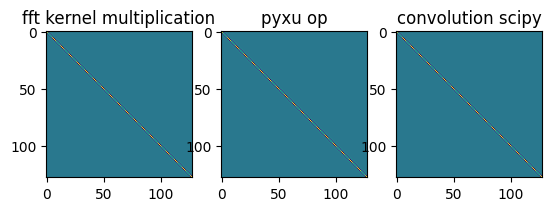

In [136]:
x = np.eye(N)
y = np.fft.fft2(x)

plt.subplot(131)
plt.title("fft kernel multiplication")
plt.imshow(np.real(np.fft.ifft2(((Lfft**2).ravel() * y.ravel()).reshape(N,N))))

plt.subplot(132)
plt.title("pyxu op")
plt.imshow(np.real((L.gram().apply(x.flatten())).reshape(N,N)))

from scipy.ndimage import laplace

plt.subplot(133)
plt.title("convolution scipy")
plt.imshow(laplace(laplace(x, mode="wrap"), mode="wrap"))


In [156]:
def FFT_L_gram_vec(op):
    Lkernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    Lpad = np.pad(Lkernel, ((0, op.N - 3), (0, op.N - 3)))
    Lroll = np.roll(Lpad, -1, axis=(0, 1))
    Lfft_real = np.flip(np.fft.fftshift(np.fft.rfft2(Lroll), axes=0), axis=0)

    samples = (1 / (2 * np.pi / op.N) * op.samples).astype(int)
    samples[:, 1] = samples[:, 1] + op.N // 2 - op.even
    Lvec = (
        op.dim_in
        / 2
        * np.repeat(
            np.real(((Lfft_real[samples[:, 1], samples[:, 0]]) ** 2).ravel()), 2
        )
    )
    return Lvec

(8191, 2)


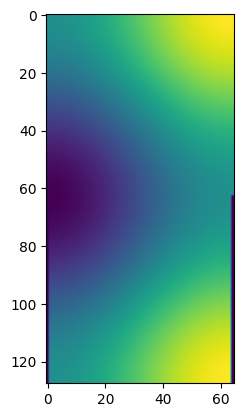

In [157]:
from pyxu.util import view_as_real, view_as_complex
keep_perc = 0.1
theta = 0.5
op = NuFFT(N, keep_perc, theta, on_grid=True, seed=seed)

y = op(x.ravel())

result_pyxu = (op.phi * L * op.phi.T).apply(y)

Lfft_real = np.flip(np.fft.fftshift(np.fft.rfft2(Lroll), axes=0),axis=0)

operator = np.zeros_like(Lfft_real)
b = (1/(2 * np.pi / op.N) * op.samples).astype(int)
b[:,1]= b[:,1] + op.N // 2 - op.even 
print(b.shape)

operator[b[:, 1], b[:, 0]] = Lfft_real[b[:, 1], b[:, 0]]
#operator = Lfft_real
plt.imshow(np.abs(operator))
result_fft = view_as_real(
    (Lfft_real[b[:, 1], b[:, 0]]).ravel() * view_as_complex(y)
)


In [159]:
# fft_arr = DiagonalOp(np.repeat(np.real(((Lfft_real[b[:, 1], b[:, 0]])**2).ravel()),2)).asarray()
# plt.subplot(121)
# plt.imshow(op.dim_in/2*fft_arr)
# plt.colorbar()

# pyxu_arr = (op.phi * L2 * op.phi.T).asarray()
# plt.subplot(122)
# plt.imshow(pyxu_arr)
# plt.colorbar();

random_y = np.random.rand(op.dim_out)

fft_op =  DiagonalOp(FFT_L_gram_vec(op))
pyxu_op = (op.phi * L.gram() * op.phi.T)
print(np.allclose(pyxu_op.apply(random_y),  fft_op.apply(random_y)))

True


In [147]:
pyxu_op.apply(random_y)

array([-6.22900054e-11, -1.96896420e-11,  5.72477239e+02, ...,
        2.51498793e+05,  9.20044323e+04,  2.79957485e+05])

In [148]:
op.dim_in/2*fft_op.apply(random_y)

array([     0.        ,      0.        ,    572.47723917, ...,
       251498.79278844,  92004.43233586, 279957.48516803])

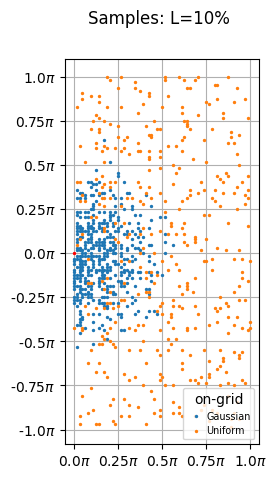

In [144]:
op.plot_samples()